In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev2, Chebyshev_L3

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

import uqtestfuns as uqtf
import numpy as np
from utils import MLP_model, fit, Regression, generate_dataset_uqtf, evaluate, non_zero_count, sparse_model, add_multi_index, prod_multi_index
from Cuda import DeviceDataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import copy

In [15]:
my_testfun =  uqtf.Borehole()
print(my_testfun)
my_testfun.spatial_dimension

Name              : Borehole
Spatial dimension : 8
Description       : Borehole function from Harper and Gupta (1983)


8

In [16]:
#my_testfun.prob_input
np.random.seed(42)

In [17]:
N = 10000
train = 0.9
N_t = int(N * train)
N_v = N - N_t



In [18]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 10
RANK = 20
LHP = 20
IN_DIM = my_testfun.spatial_dimension
OUT_DIM = 1
DEGREE = 4
loss_fn = nn.MSELoss()

In [19]:
dataset, target_scaler = generate_dataset_uqtf(my_testfun, N, MinMaxScaler())

In [20]:
train_ds, val_ds = random_split(dataset, [N_t, N_v])

In [21]:
train_loader = DeviceDataLoader(DataLoader(train_ds, BATCH_SIZE, shuffle=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, BATCH_SIZE), device)

In [22]:
#inverse = target_scaler.inverse_transform(yy_sample)


In [23]:
Canon = CP(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
Cheby = Chebyshev(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
Mlp = MLP_model(IN_DIM, OUT_DIM)
Mlp_reg = Regression(Mlp, IN_DIM, loss_fn).to(device)
Canon_reg = Regression(Canon, IN_DIM, loss_fn).to(device)
Cheby_reg = Regression(Cheby, IN_DIM, loss_fn).to(device)
optimizer = torch.optim.Adam
optimizer = torch.optim.SGD
optimizer = torch.optim.Rprop
optmizer = torch.optim.LBFGS

In [24]:
optimizer_list = [torch.optim.Adam, torch.optim.SGD, torch.optim.Rprop, torch.optim.LBFGS]

In [25]:
models = [Mlp_reg, Canon_reg, Cheby_reg]

In [34]:
n = len(models)
lists = [[] for _ in range(n)]


In [35]:
for i in range(n):
    for j in range(len(optimizer_list)):
        model_clone = copy.deepcopy(models[i])
        lists[i].append(model_clone)

In [36]:
len(lists)

3

In [1184]:
#history1, losses1 = fit(NUM_EPOCHS, LEARNING_RATE, Mlp_reg, train_loader, val_loader, opt_func=optimizer)

In [1185]:
#history2, losses2 = fit(NUM_EPOCHS, LEARNING_RATE, Canon_reg, train_loader, val_loader, opt_func=optimizer)

In [1186]:
#history3, losses3 = fit(NUM_EPOCHS, LEARNING_RATE, Cheby_reg, train_loader, val_loader, opt_func=optimizer)

In [1187]:
models = [Mlp_reg, Canon_reg, Cheby_reg]

In [1188]:
for model in models:
    history, losses = fit(NUM_EPOCHS, LEARNING_RATE, model, train_loader, val_loader, opt_func=optimizer)

Epoch [0], train_loss: 0.0011 val_loss: 0.0009
Epoch [1], train_loss: 0.0006 val_loss: 0.0008
Epoch [2], train_loss: 0.0010 val_loss: 0.0008
Epoch [3], train_loss: 0.0006 val_loss: 0.0008
Epoch [4], train_loss: 0.0005 val_loss: 0.0008
Epoch [5], train_loss: 0.0006 val_loss: 0.0008
Epoch [6], train_loss: 0.0007 val_loss: 0.0008
Epoch [7], train_loss: 0.0010 val_loss: 0.0008
Epoch [8], train_loss: 0.0008 val_loss: 0.0008
Epoch [9], train_loss: 0.0009 val_loss: 0.0008
Epoch [0], train_loss: 0.0019 val_loss: 0.0020
Epoch [1], train_loss: 0.0017 val_loss: 0.0018
Epoch [2], train_loss: 0.0024 val_loss: 0.0018
Epoch [3], train_loss: 0.0011 val_loss: 0.0017
Epoch [4], train_loss: 0.0011 val_loss: 0.0017
Epoch [5], train_loss: 0.0020 val_loss: 0.0017
Epoch [6], train_loss: 0.0024 val_loss: 0.0017
Epoch [7], train_loss: 0.0019 val_loss: 0.0017
Epoch [8], train_loss: 0.0013 val_loss: 0.0016
Epoch [9], train_loss: 0.0019 val_loss: 0.0016
Epoch [0], train_loss: 0.0145 val_loss: 0.0174


KeyboardInterrupt: 

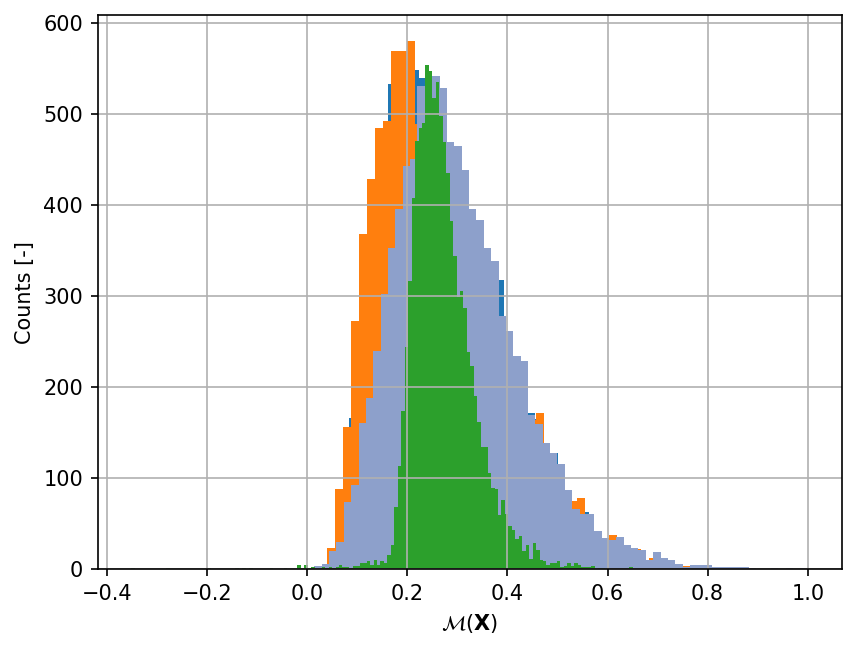

In [ ]:
test_dataset, target_scaler_test = generate_dataset_uqtf(my_testfun, N, MinMaxScaler())
for model in models:
    model.to('cpu')
    np.random.seed(41)
    outputs1 = model(test_dataset[:, :IN_DIM].to('cpu')).to('cpu').detach().numpy()
    test_target = test_dataset[:, IN_DIM:].to('cpu').detach().numpy()
    plt.hist(test_target, bins="auto", color="#8da0cb")
    plt.hist(outputs1, bins='auto')
    plt.grid()
    plt.xlabel("$\mathcal{M}(\mathbf{X})$")
    plt.ylabel("Counts [-]")
    plt.gcf().set_dpi(150);

In [ ]:
model.to('cpu')

Regression(
  (model): Chebyshev(
    (T1): Linear(in_features=8, out_features=20, bias=False)
    (T2): Linear(in_features=8, out_features=20, bias=False)
    (T3): Linear(in_features=8, out_features=20, bias=False)
    (T4): Linear(in_features=8, out_features=20, bias=False)
    (layer_C): Linear(in_features=20, out_features=1, bias=True)
  )
  (loss_function): MSELoss()
)

In [ ]:
np.random.seed(43)
test_dataset, target_scaler_test = generate_dataset_uqtf(my_testfun, N, MinMaxScaler())

In [ ]:
non_zero_count(model)

tensor(681)

In [ ]:
outputs1 = model(test_dataset[:, :IN_DIM].to('cpu')).to('cpu').detach().numpy()
test_target = test_dataset[:, IN_DIM:].to('cpu').detach().numpy()

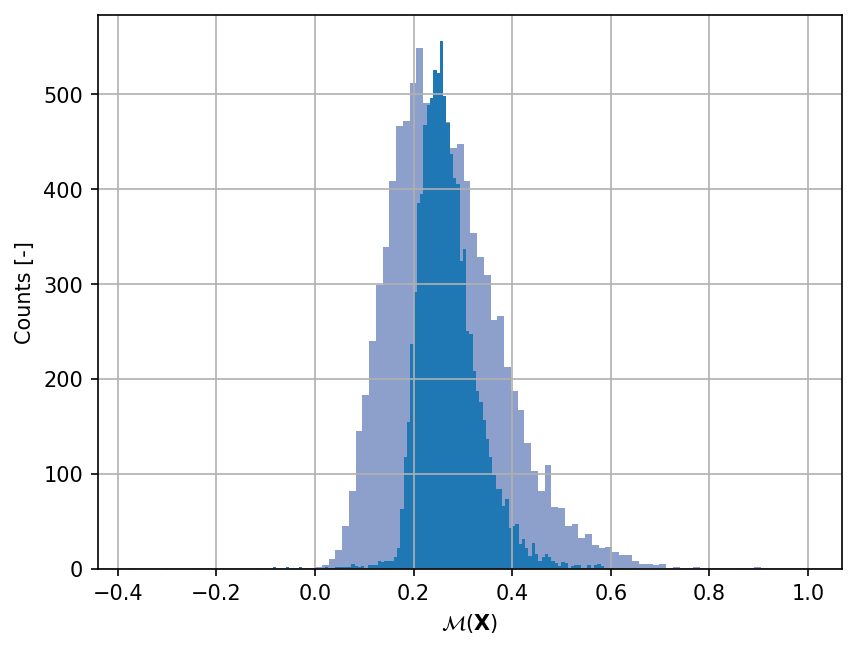

In [ ]:
import matplotlib.pyplot as plt

plt.hist(test_target, bins="auto", color="#8da0cb")
plt.hist(outputs1, bins='auto')
plt.grid()
plt.xlabel("$\mathcal{M}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.gcf().set_dpi(150);

In [ ]:
state_dict = model.state_dict()
for name, p in model.named_parameters():
    print(state_dict[name])
    mask1 = p > 0.1 
    mask2 = p < -0.1
    mask3 =  (mask1 | mask2) 
    p = nn.Parameter(mask3 * p)
    state_dict[name] = p
    print(state_dict[name])

model.load_state_dict(state_dict)

tensor([-0.0025,  0.1164,  0.2086, -0.2557,  0.1783, -0.0405,  0.0883,  0.1882,
         0.0660, -0.0477, -0.0885,  0.1515, -0.1042,  0.0113,  0.0645,  0.2004,
         0.2218, -0.0995,  0.1025, -0.1545])
Parameter containing:
tensor([-0.0000,  0.1164,  0.2086, -0.2557,  0.1783, -0.0000,  0.0000,  0.1882,
         0.0000, -0.0000, -0.0000,  0.1515, -0.1042,  0.0000,  0.0000,  0.2004,
         0.2218, -0.0000,  0.1025, -0.1545], requires_grad=True)
tensor([[ 0.1910,  0.0042, -0.3520,  0.2218, -0.3427,  0.0866, -0.0698,  0.2689],
        [ 0.2326,  0.1750,  0.3231,  0.2926, -0.2333, -0.1648, -0.1003,  0.3717],
        [ 0.2191, -0.4332, -0.2566, -0.2325,  0.2605, -0.2343, -0.1781, -0.0093],
        [-0.1019, -0.2376,  0.0025, -0.1822,  0.1157, -0.0082, -0.1694, -0.2026],
        [ 0.0531,  0.2010,  0.3530,  0.3086,  0.1814,  0.2447,  0.0916,  0.1793],
        [-0.1159, -0.0501,  0.1570, -0.2375,  0.3353, -0.0798,  0.0764, -0.1588],
        [ 0.1446,  0.1719,  0.1349,  0.2032, -0.0543, -0

<All keys matched successfully>

In [ ]:
def sparse_model(model, threshold):
    state_dict = model.state_dict()
    for name, p in model.named_parameters():
        mask1 = p > threshold
        mask2 = p < -threshold
        mask3 =  (mask1 | mask2) 
        p = nn.Parameter(mask3 * p)
        state_dict[name] = p

    model.load_state_dict(state_dict)
    return model

In [ ]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

after = torch.sum(torch.tensor(num_param))

In [ ]:
after

tensor(483)

In [ ]:
(before - after)

tensor(278)

In [ ]:
(before - after)/before *100

tensor(36.5309)

In [ ]:
def prod_multi_index(mi1, mi2):
    sum_list = []
    for i in mi2:
        tile = np.tile(i, (len(mi1),1))
        sum = mi1 + tile
        sum_list = sum_list + [sum]
        sum_array = np.vstack(tuple(sum_list))
        mi3 = np.unique(np.array(sum_array), axis=0)
    return mi3

In [ ]:
def prod_multi_index2(mi1, mi2):
    sum_list = []
    for i in mi2:
        sum = mi1 + i
        sum_list.append(sum)
    sum_array = np.vstack(tuple(sum_list))
    mi3 = np.unique(np.array(sum_array), axis=0)
    return mi3

In [ ]:
def add_multi_index(mi1, mi2):
    mi3 = np.unique(np.vstack((mi1, mi2)), axis=0)
    return mi3

In [ ]:
if isinstance(model, CP):
   sparse_param = []
   for name, p in model.named_parameters():  
      if len(p.shape) == 2:
         #print(p.shape)
         if p.shape[0] == RANK and p.shape[1] == IN_DIM:
            sparse_param = sparse_param + [p]
      

In [ ]:
if isinstance(model, CP):
    sparse_mi = []
    for i in sparse_param:
        ind = torch.where(i[0] == 0)[0].to('cpu').detach().numpy()
        mi_w = np.eye(i.shape[1])
        mi_w_s = np.delete(mi_w, ind, 0)
        sparse_mi = sparse_mi + [mi_w_s]


In [ ]:
if isinstance(model, CP):
    mi_s = sparse_mi[0]
    for i in range(1, len(sparse_mi)):
        mi1 = sparse_mi[i]
        mi_s = add_multi_index(prod_multi_index(mi_s, mi1), mi_s)

In [ ]:
isinstance(model, Chebyshev)

False

In [ ]:
isinstance(model, CP)

False

In [ ]:
if isinstance(model, Chebyshev):
   sd = model.state_dict
   sparse_param = []
   for name, p in model.named_parameters(): 
      #print(name)
      if name != 'layer_C.weight' and name != 'layer_C.bias' and name != 'T0':
         sparse_param = sparse_param + [p]
         print(name)

In [ ]:
len(sparse_param)

NameError: name 'sparse_param' is not defined

In [ ]:
if isinstance(model, Chebyshev):
    sparse_mi = []
    for i in sparse_param:
        ind = torch.where(i[0] == 0)[0].to('cpu').detach().numpy()
        mi_w = np.eye(i.shape[1])
        mi_w_s = np.delete(mi_w, ind, 0)
        sparse_mi = sparse_mi + [mi_w_s]


In [ ]:
if isinstance(model, CP):
    mi_s = sparse_mi[0]
    for i in range(1, len(sparse_mi)):
        mi1 = sparse_mi[i]
        mi_s = add_multi_index(prod_multi_index(mi_s, mi1), mi_s)

In [ ]:
if isinstance(model, Chebyshev):
    mi_list = []
    
    mi_s1 = sparse_mi[0]
    mi_s0 = np.zeros(mi_s1.shape[1])
    mi_list = mi_list + [mi_s1]
    print(mi_s0)
    for i in range(1, len(sparse_mi) + 1, 2):
        mi_s0 = add_multi_index(prod_multi_index(mi_s1, sparse_mi[i]), mi_s0)
        mi_list = mi_list + [mi_s0]
        
        if i == DEGREE - 1:
            mi_s = mi_s0
            break
        else:  
            print(i)         
            mi_s1 = add_multi_index(prod_multi_index(mi_s0, sparse_mi[i+1]), mi_s1)
            mi_list = mi_list + [mi_s1]
            mi_s = mi_s1

[0. 0. 0. 0. 0. 0. 0. 0.]
1
3


In [ ]:
index = 0
print(sparse_mi[index],)


[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
mi_list[index]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [ ]:
for i in range(1, len(sparse_mi)+1, 2):
    print(i)

1
3
5


In [ ]:
DEGREE

6

In [ ]:
outputs2 = model(input_tensor.to('cpu')).to('cpu').detach().numpy()

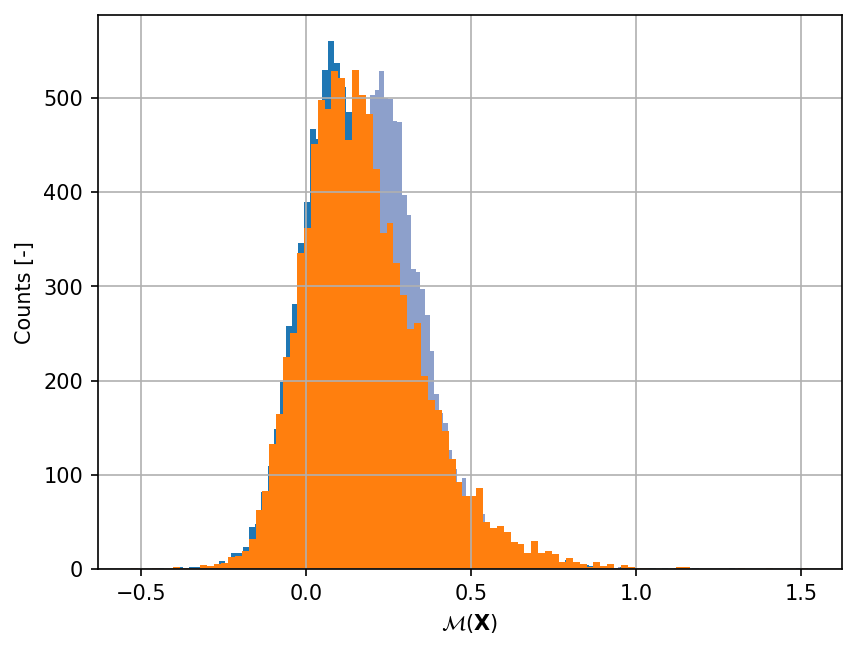

In [ ]:
import matplotlib.pyplot as plt

plt.hist(yy_sample, bins="auto", color="#8da0cb")
plt.hist(outputs2, bins='auto')
plt.hist(outputs1, bins='auto')
plt.grid()
plt.xlabel("$\mathcal{M}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.gcf().set_dpi(150);

In [ ]:
out1_inv = target_scaler.inverse_transform(outputs1) 
out2_inv = target_scaler.inverse_transform(outputs2) 

In [ ]:
average_error = np.mean(out1_inv - out2_inv)

In [ ]:
average_error

7.5214596

In [ ]:
np.mean(target_scaler.inverse_transform(yy_sample))

72.94882935911545

In [ ]:
mse = ((out1_inv - out2_inv)**2).mean(axis = 0)

In [ ]:
mse

array([305.399], dtype=float32)

In [ ]:
model.to(device)

Chebyshev(
  (T1): Linear(in_features=8, out_features=10, bias=False)
  (T2): Linear(in_features=8, out_features=10, bias=False)
  (T3): Linear(in_features=8, out_features=10, bias=False)
  (T4): Linear(in_features=8, out_features=10, bias=False)
  (T5): Linear(in_features=8, out_features=10, bias=False)
  (T6): Linear(in_features=8, out_features=10, bias=False)
  (layer_C): Linear(in_features=10, out_features=1, bias=True)
)

https://github.com/polynomial-nets/tutorial-2022-intro-polynomial-nets/blob/master/pytorch/Minimum_example_pytorch.ipynb

In [ ]:
'''class Chebyshev(nn.Module):
    def __init__(self, degree, d, k, o):
        super(Chebyshev, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.T0 = nn.Linear(k, 1).weight.to(torch.float32)[0]
        for i in range(1, self.degree + 1):
            setattr(self, 'T{}'.format(i), nn.Linear(self.input_dimension, self.rank, bias=False)) 

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out0 = self.T0
        out1 = self.T1(z)
        out_list = [out0] + [out1]
        for i in range(2, self.degree + 1, 2):
            print(i)
            out0 = getattr(self, 'T{}'.format(i))(z) * 2 * out1 - out0
            out_list = out_list + [out0]
            if i == self.degree:
                print(i)
                x = self.layer_C(out_list[self.degree])
                return x, out_list
            else:
                print(i + 1)
                out1 = getattr(self, 'T{}'.format(i + 1))(z) * 2 * out0 - out1
                out_list = out_list + [out1]
        x = self.layer_C(out_list[self.degree])
        return x, out_list'''

"class Chebyshev(nn.Module):\n    def __init__(self, degree, d, k, o):\n        super(Chebyshev, self).__init__()        \n     \n        self.input_dimension = d \n        self.rank = k\n        self.output_dimension = o \n        self.degree = int(degree)\n        self.T0 = nn.Linear(k, 1).weight.to(torch.float32)[0]\n        for i in range(1, self.degree + 1):\n            setattr(self, 'T{}'.format(i), nn.Linear(self.input_dimension, self.rank, bias=False)) \n\n        self.layer_C = nn.Linear(self.rank, self.output_dimension) \n\n\n    def forward(self, z):\n        z = z.reshape(-1, self.input_dimension)\n        out0 = self.T0\n        out1 = self.T1(z)\n        out_list = [out0] + [out1]\n        for i in range(2, self.degree + 1, 2):\n            print(i)\n            out0 = getattr(self, 'T{}'.format(i))(z) * 2 * out1 - out0\n            out_list = out_list + [out0]\n            if i == self.degree:\n                print(i)\n                x = self.layer_C(out_list[self.deg

In [ ]:
cheby =  Chebyshev(16,2,8,2)
cheby2 = Chebyshev2(2,2,2)

In [ ]:
degrees = [3, 2, 3]
#rank = [20, 30, 25]
layer_params = [8, 20, 30, 20]
output = 1
layers = len(degrees)

'''layer_1 = Chebyshev2(degrees[0], inputs[0], inputs[1])
layer_2 = Chebyshev2(degrees[1], inputs[1], inputs[2])
layer_3 = Chebyshev2(degrees[2], inputs[2], inputs[3])'''

'layer_1 = Chebyshev2(degrees[0], inputs[0], inputs[1])\nlayer_2 = Chebyshev2(degrees[1], inputs[1], inputs[2])\nlayer_3 = Chebyshev2(degrees[2], inputs[2], inputs[3])'

In [ ]:
#outputs = [input[1], input[2], output]
layer_list = []
for i in range(layers):
    print(i)
    layer_list.append(Chebyshev2(degrees[i], layer_params[i], layer_params[i+1]))


0
1
2


In [ ]:
z = torch.randn(8)
C = nn.Linear(layer_params[3], output )


In [ ]:
for i in layer_list:
    z = i(z)

In [ ]:
C.weight

Parameter containing:
tensor([[-0.1253, -0.0883, -0.2119,  0.1546, -0.0099,  0.0187,  0.0163,  0.0578,
         -0.1927, -0.1319,  0.1745,  0.0960, -0.1815, -0.1197,  0.2145,  0.0752,
          0.0050, -0.1942, -0.0755, -0.0590]], requires_grad=True)

In [ ]:
out = C(z)

In [ ]:
     '''   for i in range(self.layers):
            setattr(self, 'layer{}'.format(i+1), Chebyshev2(degrees[i], layer_params[i], layer_params[i+1])) '''

"   for i in range(self.layers):\n       setattr(self, 'layer{}'.format(i+1), Chebyshev2(degrees[i], layer_params[i], layer_params[i+1])) "

In [ ]:
class ProdCheby(nn.Module):
    def __init__(self, layer_params = [], degrees = [], output = 1):
        super(ProdCheby, self).__init__()   
        
        self.input_dimension = layer_params[0]
        self.output_dimension = output
        self.num_layers = len(degrees)
        for i in range(self.num_layers):
            setattr(self, 'layer{}'.format(i+1), Chebyshev2(degrees[i], layer_params[i], layer_params[i+1])) 
        self.layer_C = nn.Linear(layer_params[self.num_layers], self.output_dimension)

    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        for i in range(self.num_layers):
            z = getattr(self, 'layer{}'.format(i+1))(z)
        x = self.layer_C(z)    
        return x


In [ ]:
class ProdCheby2(nn.Module):
    def __init__(self, layer_params = [], degrees = [], output = 1):
        super(ProdCheby2, self).__init__()   
        
        self.input_dimension = layer_params[0]
        self.output_dimension = output
        self.num_layers = len(degrees)
        for i in range(self.num_layers-1):
            setattr(self, 'layer{}'.format(i+1), Chebyshev(degrees[i], layer_params[i], layer_params[i+1], layer_params[i+1])) 
        setattr(self, 'layer{}'.format(self.num_layers), Chebyshev(degrees[self.num_layers-1], layer_params[self.num_layers-1], layer_params[self.num_layers], self.output_dimension))
        #self.layer_C = nn.Linear(layer_params[self.num_layers], self.output_dimension)

    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        for i in range(self.num_layers):
            z = getattr(self, 'layer{}'.format(i+1))(z)
        #x = self.layer_C(z)    
        return z


In [ ]:
class ProdCheby_NL(nn.Module):
    def __init__(self, layer_params = [], degrees = [], output = 1, activation = nn.ReLU()):
        super(ProdCheby_NL, self).__init__()   
        
        self.input_dimension = layer_params[0]
        self.output_dimension = output
        self.num_layers = len(degrees)
        self.activation = activation
        for i in range(self.num_layers-1):
            setattr(self, 'layer{}'.format(i+1), Chebyshev(degrees[i], layer_params[i], layer_params[i+1], layer_params[i+1])) 
        setattr(self, 'layer{}'.format(self.num_layers), Chebyshev(degrees[self.num_layers-1], layer_params[self.num_layers-1], layer_params[self.num_layers], self.output_dimension))
        #self.layer_C = nn.Linear(layer_params[self.num_layers], self.output_dimension)

    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        for i in range(self.num_layers-1):
            z = self.activation(getattr(self, 'layer{}'.format(i+1))(z))
        z = getattr(self, 'layer{}'.format(self.num_layers))(z)
        #x = self.layer_C(z)    
        return z

In [ ]:
class ProdCheby_NL(nn.Module):
    def __init__(self, layer_params = [], degrees = [], output = 1, activation = nn.ReLU()):
        super(ProdCheby_NL, self).__init__()   
        
        self.input_dimension = layer_params[0]
        self.output_dimension = output
        self.num_layers = len(degrees)
        self.activation = activation
        for i in range(self.num_layers-1):
            setattr(self, 'layer{}'.format(i+1), Chebyshev(degrees[i], layer_params[i], layer_params[i+1], layer_params[i+1])) 
        setattr(self, 'layer{}'.format(self.num_layers), Chebyshev(degrees[self.num_layers-1], layer_params[self.num_layers-1], layer_params[self.num_layers], self.output_dimension))
        #self.layer_C = nn.Linear(layer_params[self.num_layers], self.output_dimension)

    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        for i in range(self.num_layers):
            z = self.activation(getattr(self, 'layer{}'.format(i+1))(z))
        #x = self.layer_C(z)    
        return z

In [ ]:
d = 3
rank = 20
degrees = [3]
#rank = [20, 30, 25]
layer_params = [d, rank]
output = 2
layers = len(degrees)

In [ ]:
cheb1 = ProdCheby(layer_params, degrees, output)
cheb2 = ProdCheby2(layer_params, degrees, output)
cheb3 = Chebyshev(*degrees, d, rank, output)
cheb4 = Chebyshev_L3(d, rank, output)

In [ ]:
cheb2.layer1

Chebyshev(
  (T1): Linear(in_features=3, out_features=20, bias=False)
  (T2): Linear(in_features=3, out_features=20, bias=False)
  (T3): Linear(in_features=3, out_features=20, bias=False)
  (layer_C): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
non_zero_count(cheb2)

tensor(242)

In [ ]:
z = torch.randn(2, 2)

In [ ]:
cheb(z)

NameError: name 'cheb' is not defined

In [ ]:
non_zero_count(cheb)

tensor(4581)

In [ ]:
cheb.num_layers

3

In [ ]:
for i in range(1):
    print(i)

0
